<div>
<h1>1) Energy-Based Novelty</h1> 
</div>

## Local Energy Function

Often a note onset goes along with a sudden increase of the signal's energy. Based on this assumption, a straightforward way to detect note onsets is to transform the signal into a local energy function that indicates 
the local energy of the signal for each time instance and then to look for sudden changes in this function. Let $x:\mathbb{Z}\to\mathbb{R}$ be a DT-signal. Furthermore, let $w:[-M:M]\to\mathbb{R}$ for some $M\in\mathbb{N}$ be a bell-shaped window function centered at time zero (e.g., a Hann window). The **local energy** of $x$ with regard to $w$ is defined to be the function $E_w^x:\mathbb{Z}\to\mathbb{R}$ given by 

\begin{equation}
 E_w^x(n) := \sum_{m=-M}^{M} |x(n+m)w(m)|^2 = \sum_{m\in\mathbb{Z}}|x(m)w(m-n)|^2
\end{equation}

In the following figures, we continue our Queen example "Another one bites the dust".

In [1]:
import os, sys
import sys
import numpy as np
from scipy import signal
from  matplotlib import pyplot as plt
import librosa
import IPython.display as ipd

In [2]:
onsets = [0.117460317, 0.247619048, 0.646349206, 1.184761905, 1.735238095, 2.287619048]
beats = [0.372698413, 0.911111111, 1.445442177,  2.000000000]

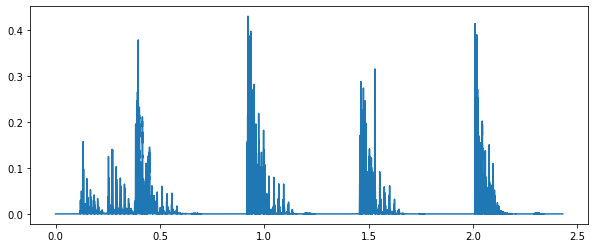

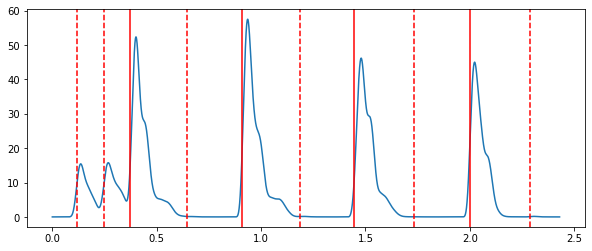

In [6]:
fn_wav = os.path.join('audio', 'Queen.wav')
x, Fs = librosa.load(fn_wav, sr=None)
time_axis = np.arange(x.shape[0]) / Fs

N = 2048
w = signal.hann(N)

L = x.shape[0]
energy_local = np.zeros((L, ))
x_padded = np.pad(x, (N//2, N//2))

for n in np.arange(L):
    energy_local[n] = np.sum((x_padded[n : n + N] * w)**2)
    
x_squared = x**2

plt.figure(figsize=(10, 4))
plt.plot(time_axis,x_squared)

plt.figure(figsize=(10, 4))
plt.plot(time_axis, energy_local)

for b in beats:
    plt.axvline(b, color='red')
for o in onsets:
    plt.axvline(o, color='red', linestyle='--')

## Discrete Derivative and Half-Wave Rectification

To measure energy changes, we take a derivative of the local energy function. In the discrete case, the easiest way to realize such a derivative is to take the difference between two subsequent energy values. 
Formally the discrete derivative is defined as: 

\begin{equation}
    \Delta x(n) := x(n + 1) - x(n)
\end{equation}


Furthermore, since we are interested in energy increases (and not decreases), we keep only the positive differences while setting the negative differences to zero. The latter step is known as **half-wave rectification** and is notated as: 

\begin{equation}
   |r|_{\geq 0} := \frac{r+|r|}{2} =
   \left\{\begin{array}{ll}
    r, &\,\, \mbox{if $r\geq 0$,}\\
    0, &\,\, \mbox{if $r< 0$}
\end{array}\right.
\end{equation}

for $r\in\mathbb{R}$. Altogether, we obtain an **energy-based novelty function** $\Delta_\mathrm{Energy}:\mathrm{Z}\to\mathbb{R}$ given by 

\begin{equation}
   \Delta_\mathrm{Energy}(n):= |E_w^x(n+1)-E_w^x(n)|_{\geq 0}
\end{equation}

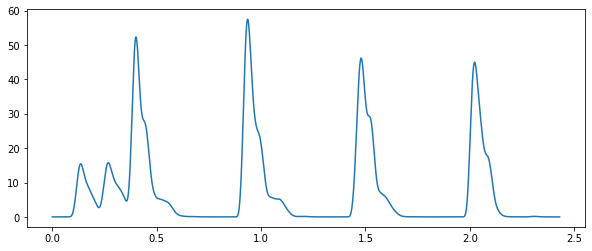

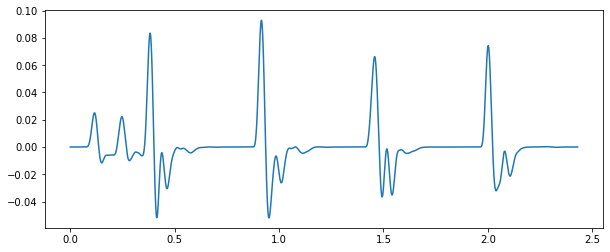

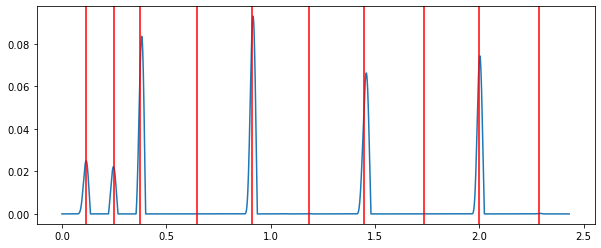

In [8]:
energy_local_diff = np.diff(energy_local)
energy_local_diff = np.concatenate((energy_local_diff, np.array([0])))

novelty_energy = np.copy(energy_local_diff)
novelty_energy[novelty_energy < 0] = 0

plt.figure(figsize=(10,4))
plt.plot(time_axis, energy_local)

plt.figure(figsize=(10,4))
plt.plot(time_axis, energy_local_diff)

plt.figure(figsize=(10,4))
plt.plot(time_axis, novelty_energy)

for b in beats:
    plt.axvline(b, color='red')
for o in onsets:
    plt.axvline(o, color='red')

Note that this novelty function nicely indicates that the percussive beats contain a lot of energy. The low-energy hihat strokes in between, however, are not visible. Note that the **smoothing effect** introduced by the bell-shaped Hann windowed is essential in this procedure when applying a simple framewise difference function. For example, using a **rectangular window** instead, the difference function reacts to small local fluctuations leading to a noisy energy function. This is demonstrated by the following figure.

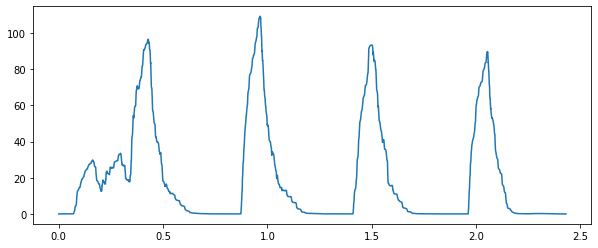

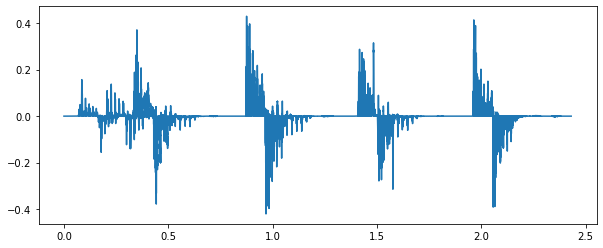

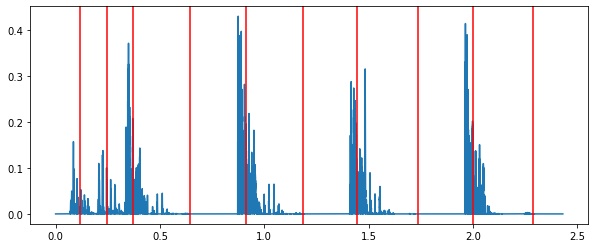

In [9]:
w = signal.boxcar(N)

L = x.shape[0]
energy_local = np.zeros((L, ))
x_padded = np.pad(x, (N//2, N//2))
for n in np.arange(L):
    energy_local[n] = np.sum((x_padded[n:n+N] * w)**2)

energy_local = np.convolve(x**2, w**2, 'same')

energy_local_diff = np.diff(energy_local)
energy_local_diff = np.concatenate((energy_local_diff, np.array([0])))

novelty_energy = np.copy(energy_local_diff)
novelty_energy[novelty_energy <0] = 0

plt.figure(figsize=(10,4))
plt.plot(time_axis, energy_local)

plt.figure(figsize=(10,4))
plt.plot(time_axis, energy_local_diff)

plt.figure(figsize=(10,4))
plt.plot(time_axis, novelty_energy)

for b in beats:
    plt.axvline(b, color='red')
for o in onsets:
    plt.axvline(o, color='red')

## Logarithmic Compression

To account for the fact that human perception of sound intensity is logarithmic in nature,  one often applies a logarithm to the energy values, for example, by switching to the logarithmic decibel or by applying **logarithmic compression**. We use the function $\Gamma_\gamma:\mathbb{R}_{>0} \to \mathbb{R}_{>0}$ defined by 

\begin{equation}
   \Gamma_\gamma(v):=\log(1+ \gamma \cdot v),
\end{equation}

where the positive constant $\gamma\in\mathbb{R}_{>0}$ regulates the degree of compression. The resulting novelty function is given by:

\begin{equation}
   \Delta_\mathrm{Energy}^\mathrm{Log}(n):= |\Gamma_\gamma(E_w^x(n+1))-\Gamma_\gamma(E_w^x(n))|_{\geq 0}.
\end{equation}

Besides the window length $N$, we introduce in the following implementation also a **downsampling parameter** $J$, which allows for decreasing the feature sampling rate of the computed novelty. 

Furthermore, dividing by its maximum value, we **normalize** the novelty function. In the next figure, continuing our running example, one can observe that some of the weak hihat onsets become visible (see $t=1.3~\mathrm{sec}$ and $t=2.3~\mathrm{sec}$) when using a logarithmic novelty function. As a downside of logarithmic compression, some noise-like sound components may be amplified, possibly leading to spurious peaks. As shown in this example, logarithmic compression also shifted some peak positions forward, now preceding the reference annotations (shown in red). This may indicate that the reference annotations, which were generated manually by a human listener, correspond to slightly delay "perceived" onset positions. 

In [ ]:
downsample = x[::J]
max_value = np.max(x)
x_normalized = x / max_value

## Implementation
Implement the complete pipeline for energy-based novelty computation.

Recap:
<ol>
    <li> compute local energy </li>
    <li> apply downsampling using factor $J$</li>
    <li> apply logarithmic compression using the parameter $\gamma$ (using log function from numpy) </li>
    <li> take the derivative and apply half wave rectification </li>
    <li> normalize the result </li>

In [14]:
def compute_novelty_energy(x, Fs=1, N=2048, J=128, gamma=10, norm=1):
    w = signal.hann(N)
    energy_local = np.convolve(x**2, w**2, 'same')
    
    energy_local = energy_local[::J]
    Fs_nov = Fs/J
    
    if gamma != None:
        energy_local = np.log(1 + energy_local * gamma)
    
    energy_local_diff = np.diff(energy_local)
    energy_local_diff = np.concatenate((energy_local_diff, 
                                       np.array([0])))
    novelty_energy = np.copy(energy_local_diff)
    novelty_energy[novelty_energy < 0 ] = 0
    
    if norm == 1:
        max_value = np.max(novelty_energy)
        if max_value > 0:
            novelty_energy = novelty_energy / max_value
        
    return novelty_energy, Fs_nov

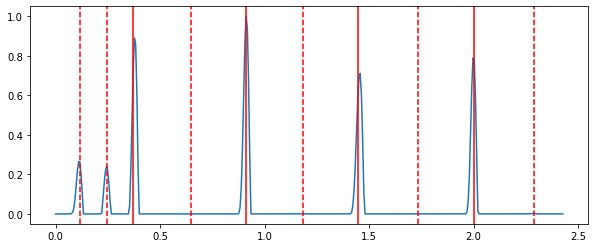

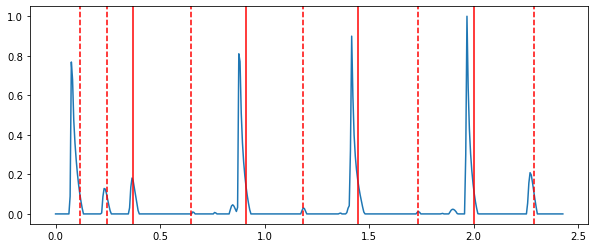

In [16]:
N = 2048
J = 128

nov_1, Fs_nov = compute_novelty_energy(x, Fs=Fs, N=N, J=J, gamma=None)
nov_2, Fs_nov = compute_novelty_energy(x, Fs=Fs, N=N, J=J, gamma=1000)

feature_time_axis = np.arange(nov_1.shape[0]) / Fs_nov

plt.figure(figsize=(10,4))
plt.plot(feature_time_axis, nov_1)
for b in beats:
    plt.axvline(b, color='red')
for o in onsets:
    plt.axvline(o, color='red', linestyle='--')
    
plt.figure(figsize=(10, 4))
plt.plot(feature_time_axis, nov_2)

for b in beats:
    plt.axvline(b, color='red')
for o in onsets:
    plt.axvline(o, color='red', linestyle='--')

## Example: Note Onsets for Different Instruments

Another general problem in onset detection is energy fluctuation in nonsteady sounds as a result of vibrato or tremolo. Especially for purely energy-based procedures, amplitude modulations often lead to spurious peaks in the resulting novelty function. This is demonstrated by the following examples, which show the energy-based novelty function for the note $\mathrm{C}4$ played by different instruments. While the novelty function shows a single clear peak in the case of a piano sound, there are many additional peaks in the case of a violin or flute sound. Furthermore, the relatively slow energy increase at the beginning of the violin sound my lead to a smeared and temporally inaccurate onset peak.


In [18]:
onsets = [0.891383220, 4.684444444, 8.835555556, 13.243174603]

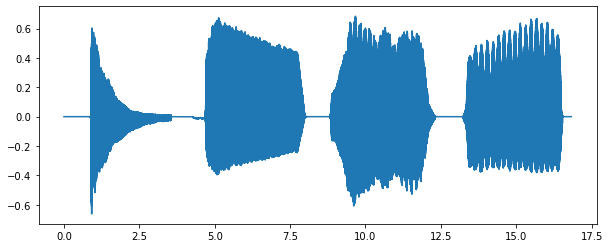

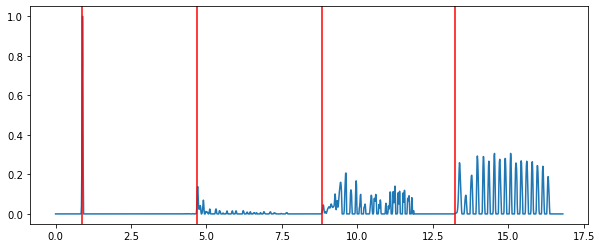

In [19]:
fn_wav = os.path.join('audio', 'noteC4_PTVF.wav')
x , Fs = librosa.load(fn_wav)

N = 2048
J = 256
nov, Fs_nov = compute_novelty_energy(x, Fs=Fs, N=N, J=J, gamma=None)

time_axis = np.arange(x.shape[0]) / Fs
plt.figure(figsize=(10,4))
plt.plot(time_axis, x)

feature_time_axis = np.arange(nov.shape[0]) / Fs_nov
plt.figure(figsize=(10, 4))
plt.plot(feature_time_axis, nov)

for o in onsets:
    plt.axvline(o, color='red')

<div>
<h1>2) Spectral-Based Novelty</h1> 
</div>

## Spectral-Based Novelty

Onset detection often becomes a hard and ill-defined problem for polyphonic music with simultaneously occurring sound events. For example, a musical event of low intensity may be masked by an event of high intensity. However, a noise-like broadband transients may be still observable in certain frequency bands even in polyphonic mixtures. Motivated by such observations, the idea of **spectral-based novelty** detection is to first convert the signal into a time&ndash;frequency representation and then to capture changes in the frequency content. 
<br>
In the following, let $\mathcal{X}$ be the discrete STFT of the DT-signal $x$ using the sampling rate $F_\mathrm{s}$, the window length $N$, and the and the hop size $H$. Recall that $\mathcal{X}(n,k)\in\mathbb{C}$ denotes the $k^\mathrm{th}$ Fourier coefficient for frequency index $k\in[0:K]$ and time frame $n\in\mathbb{Z}$, where $K=N/2$ is the frequency index corresponding to the Nyquist frequency. To detect spectral changes in the signal, one basically computes the difference between subsequent spectral vectors using a suitable distance measure. This results in a **spectral-based novelty function**, which is also known as the **spectral flux**. There are many different ways of computing such a novelty function, which depend not only on the parameters of the STFT and the distance measure, but also on pre- and postprocessing steps that are often applied. In the following, we describe a typical procedure.

## Logarithmic Compression

First, to enhance weak spectral components, we apply a **logarithmic compression** to the spectral coefficients. To this end, we apply the function $\Gamma_\gamma$ to the magnitude spectrogram $|\mathcal{X}|$ yielding

\begin{equation}
   \mathcal{Y}:=\Gamma_\gamma(|\mathcal{X}|)=\log(1+ \gamma \cdot |\mathcal{X}|)
\end{equation}

for a suitable constant $\gamma \geq 1$. The importance of logarithmic compression is illustrated by the following figure, which continues our Queen example "Another one bites the dust". Using a compressed spectrogram with $\gamma=1$, the vertical structures of the transients become more prominent&mdash;even the weak transients of the hihat between subsequent beats become visible. By increasing $\gamma$, the low-intensity values are further enhanced, in particular in the high-frequency range of the spectrogram. On the downside, a large compression factor $\gamma$ may also amplify nonrelevant noise-like components.


In [10]:
onsets = [0.117460317, 0.247619048, 0.646349206, 1.184761905, 1.735238095, 2.287619048]
beats = [0.372698413, 0.911111111, 1.445442177,  2.000000000]

## Discrete Derivative, Half-Wave Rectification, Accumulation

In the next step, we compute the discrete temporal derivative of the compressed spectrum $\mathcal{Y}$. Similarly to the energy-based novelty function, we only consider the positive differences (increase in intensity) and discard negative ones by applying **half-wave rectification**. Finally we add up the positive differences over the frequency axis (**accumulation** step), which  yields the **spectral-based novelty function** $\Delta_\mathrm{Spectral}:\mathbb{Z}\to \mathbb{R}$: 

\begin{equation}
   \Delta_\mathrm{Spectral}(n):= \sum_{k=0}^K  \big|\mathcal{Y}(n+1,k)-\mathcal{Y}(n,k)\big|_{\geq 0}
\end{equation}

for $n\in\mathbb{Z}$. As for our Queen example, the resulting novelty curve nicely indicates the percussive beats (with high energy) as well as the low-energy hihat strokes in between.

## Subtracting Local Average 

One can further enhance the properties of the novelty function by applying suitable **postprocessing steps**. For example, in view of a subsequent peak-picking step, one objective may be to enhance the peak structure of the novelty function, while suppressing small fluctuations. To this end, we introduce a local average
function $\mu:\mathbb{Z}\to\mathbb{R}$ by setting 

\begin{equation}
   \mu(n):= \frac{1}{2M+1}\sum_{m=-M}^M  \Delta_\mathrm{Spectral}(n+m),
\end{equation}

$n\in\mathbb{Z}$, where the parameter $M\in\mathbb{N}$ determines the size of an averaging window. The enhanced novelty function $\bar{\Delta}_\mathrm{Spectral}$ is obtained by subtracting the local average from $\Delta_\mathrm{Spectral}$ and by only keeping the positive part (half-wave rectification):

\begin{equation}
   \bar{\Delta}_\mathrm{Spectral}(n):= \big|\Delta_\mathrm{Spectral}(n)-\mu(n)\big|_{\geq 0}
\end{equation}

for $n\in\mathbb{Z}$. In the following implementation, we specify the length of the averaging window in seconds. Furthermore, we normalize the resulting novelty function by dividing it by its maximum value.


## Implementation

Implement the complete pipeline for spectral-based novelty computation.

Recap:
<ol>
    <li> compute the STFT and take the magnitude (spectrogram) </li>
    <li> apply logarithmic compression to the spectrogram </li>
    <li> take the derivative along time axis and apply half wave rectification </li>
    <li> sum over the frequency axis </li>
    <li> subtract local average (and re-apply half wave rectification) </li>
    <li> normalize the result </li>

In [ ]:
def compute_novelty_spectrum(x, Fs=1, N=1024, H=256, gamma=100, M=10, norm=1):
    return